In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp
import cvxopt
from tqdm import tqdm
import seaborn as sb
from scipy.stats import skewnorm
from scipy.optimize import minimize
import pickle

In [2]:
# Fill in missing based on elo ratings
def win_rate_elo(elo1, elo2, alpha = np.log(10)/400):
    """
    Computes win rate of player 1 to player 2 given their elo ratings
    """
    return 1 / (1 + np.exp(-alpha * (elo1 - elo2)))

In [3]:
df = pd.read_csv('Data/2019/2019_All.csv')

In [4]:
df = df.iloc[:, 1:]
df

,White,Black,Result,WhiteElo,BlackElo
0,monxo1978,playanotherone,0-1,946,1805
1,Nurcancakmaz,notwey,0-1,800,854
2,Enamul,ARCHAVATAR72,1-0,1910,1592
3,almostbeatlevel0,TheWiseKitty,0-1,1030,983
4,bonecollector,Hulkiorra,1-0,2034,1827
...,...,...,...,...,...
1439995,walterjaramillo,jj1987,0-1,2225,2196
1439996,abhijeetbmeut28,Sauvier,0-1,1798,1774
1439997,elmatador321,dagenssuppe,0-1,1954,1956
1439998,jawad_baddad33,Mala-Mia,0-1,1810,1856


In [5]:
df.head()

,White,Black,Result,WhiteElo,BlackElo
0,monxo1978,playanotherone,0-1,946,1805
1,Nurcancakmaz,notwey,0-1,800,854
2,Enamul,ARCHAVATAR72,1-0,1910,1592
3,almostbeatlevel0,TheWiseKitty,0-1,1030,983
4,bonecollector,Hulkiorra,1-0,2034,1827


In [6]:
df = df.rename(columns = {'White': 'white_player', 'Black': 'black_player', 'Result':'result',
                         'WhiteElo': 'white_elo', 'BlackElo':'black_elo'})

df.head()

,white_player,black_player,result,white_elo,black_elo
0,monxo1978,playanotherone,0-1,946,1805
1,Nurcancakmaz,notwey,0-1,800,854
2,Enamul,ARCHAVATAR72,1-0,1910,1592
3,almostbeatlevel0,TheWiseKitty,0-1,1030,983
4,bonecollector,Hulkiorra,1-0,2034,1827


In [7]:
df[df['result'] == '*']

,white_player,black_player,result,white_elo,black_elo
492,sylou2512,kirik14,*,1720,1727
947,arvischess,artur_777,*,2405,1592
1580,Goriainov_Oleg,Ditto,*,1760,1620
6742,Avrile,drill64,*,2018,1996
6781,zeynepogurlu04,efeduran,*,1540,1879
...,...,...,...,...,...
1439949,eoneka,a99987,*,1326,1272
1439960,zineeddine,yanstyle,*,1535,1163
1439961,ealtun,Dimka_854_0705,*,1016,868
1439978,vinas003,adriannez,*,1874,1692


In [8]:
possible_results = ['0-1', '1-0', '1/2-1/2']
drop_idx = df[~df['result'].isin(possible_results)].index
df = df.drop(drop_idx)

df[df['result'] == '*']

,white_player,black_player,result,white_elo,black_elo


Drop unknown elo ratings

In [9]:
drop_idx = df[df['white_elo'] == '?'].index
df = df.drop(drop_idx)

df[df['white_elo'] == '?']

,white_player,black_player,result,white_elo,black_elo


In [10]:
drop_idx = df[df['black_elo'] == '?'].index
df = df.drop(drop_idx)

df[df['black_elo'] == '?']

,white_player,black_player,result,white_elo,black_elo


In [11]:
# Convert to win-draw-lose
df.loc[df['result'] == '0-1', 'result'] = -1
df.loc[df['result'] == '1-0', 'result'] = 1
df.loc[df['result'] == '1/2-1/2', 'result'] = 0

In [12]:
# Convert ratings to integers
df['white_elo'] = np.array(df['white_elo']).astype('int64')
df['black_elo'] = np.array(df['black_elo']).astype('int64')

In [13]:
white_elos = np.array(df['white_elo'])
black_elos = np.array(df['black_elo'])

(array([8.94600e+03, 1.03074e+05, 2.59991e+05, 3.86119e+05, 3.76150e+05,
        2.21501e+05, 6.95870e+04, 1.22790e+04, 1.41300e+03, 8.90000e+01]),
 array([ 600. ,  853.2, 1106.4, 1359.6, 1612.8, 1866. , 2119.2, 2372.4,
        2625.6, 2878.8, 3132. ]),
 <BarContainer object of 10 artists>)

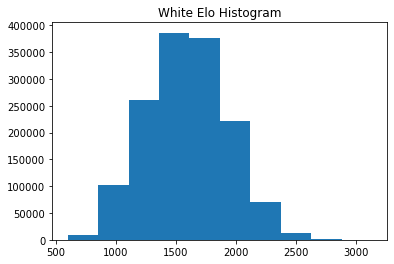

In [14]:
plt.title('White Elo Histogram')
plt.hist(white_elos)

(array([9.71900e+03, 1.10016e+05, 2.74726e+05, 3.97610e+05, 3.73612e+05,
        2.04424e+05, 5.88270e+04, 9.26300e+03, 9.19000e+02, 3.30000e+01]),
 array([ 600. ,  858.4, 1116.8, 1375.2, 1633.6, 1892. , 2150.4, 2408.8,
        2667.2, 2925.6, 3184. ]),
 <BarContainer object of 10 artists>)

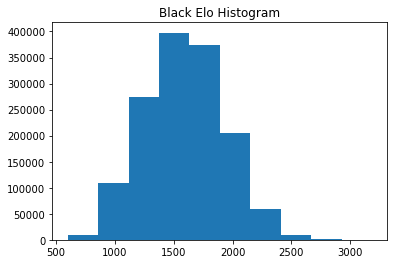

In [15]:
plt.title('Black Elo Histogram')
plt.hist(black_elos)

In [16]:
white_ratings, counts = np.unique(white_elos, return_counts = True)
black_ratings, counts = np.unique(black_elos, return_counts = True)

In [17]:
white_min = np.min(white_elos); white_max = np.max(white_elos)
black_min = np.min(black_elos); black_max = np.max(black_elos)

print(f"For white, min = {white_min}, max = {white_max}")
print(f"For black, min = {black_min}, max = {black_max}")

# Bounds should be the 'loose' one. Might want to cut down in case there's no matchups
lb = min(white_min, black_min); ub = max(white_max, black_max)
print(f"Bins range {lb} - {ub}")

For white, min = 600, max = 3132
For black, min = 600, max = 3184
Bins range 600 - 3184


## Creating the payoffs

### Method 1: Sample uniformly n-bins from the range above, and average the win rate. Win counts for +1, loss -1, draw 0

In [18]:
def create_bins(lower_bound, upper_bound, n):
    width = (upper_bound - lower_bound) / n
    
    ub = lower_bound + width; lb = lower_bound; bins = [(lb, ub)]
    for _ in range(n-1):
        lb += width; ub += width; bins.append((lb, ub))
    
    return bins

def within(bin_range, num):
    return num >= bin_range[0] and num < bin_range[1]

In [99]:
# Check if data contains lower ratings beating greater ratings
sieve_greater = (df['white_elo'] <= df['black_elo']) & (df['result'] >= 0)
df[sieve_greater]

,game_id,type,result,white_player,black_player,white_elo,black_elo
Index,,,,,,,
1,WagNiFfQ,Blitz,0,batyko,ahli_blunder,1826,1826
20,AAYKnWvt,Bullet,1,KingofKings7,alico1903,2046,2127
25,7da3nkeh,Bullet,1,hshisug,Vperezgm,1887,1924
26,M0Sl5CVI,Rapid,1,RRSR,jvmaximus,1903,1930
38,EuGDHldp,Bullet,1,super-code_ru,Misilleme,800,872
...,...,...,...,...,...,...,...
15961,h8VdqGR9,Bullet,1,AUSTIN_PRINCE,kligs,1447,1461
15962,doApPb6F,Blitz,1,zx14,KadrinEfe,1297,1308
15965,PKRUE0x0,Rapid,1,panscrub5,vezir_mat,1672,1672


In [100]:
# Check if data contains lower ratings beating greater ratings
sieve_greater = (df['black_elo'] <= df['white_elo']) & (df['result'] <= 0)
df[sieve_greater]

,game_id,type,result,white_player,black_player,white_elo,black_elo
Index,,,,,,,
0,mAEz2AcC,Rapid,-1,AliKhaled,ifospor,1702,1628
1,WagNiFfQ,Blitz,0,batyko,ahli_blunder,1826,1826
8,Tr8HhqHt,Blitz,-1,BMWX5,nistvana83,1941,1894
9,53OXpsTy,Bullet,-1,Vperezgm,Telesforus,1935,1921
10,fHwNFnEm,Blitz,-1,ahhatip,inalcik,1133,944
...,...,...,...,...,...,...,...
15950,Bc0MxCBM,Bullet,-1,anton1dalnikovich,Pravin171,1409,1396
15955,3dslmEH7,Blitz,-1,forrest92,Veter-Peremen,1863,1837
15963,vuDze9mH,Blitz,-1,Stock2020,Pavlodar_pvl,2165,2165


In [16]:
wlb, wub = (1829, 1832); blb, bub = (2001, 2003)

In [17]:
sieve_w = (df['white_elo'] < wub) & (df['white_elo'] > wlb)
df_sieve_w = df[sieve_w]
df_sieve_w['black_elo'].unique()

array([1792, 1841, 1983, 1805, 1925, 1763, 1751, 1778, 1872, 1721, 1756,
       1881, 1620, 1724, 1842, 2104, 1704, 1829, 1830, 1803, 1781, 1686,
       1557, 1573, 1546, 2013, 1959, 1860, 1806, 1956, 1862, 1657, 1764,
       2078, 1838, 1749, 1865, 1766, 1699, 1583, 1691, 1807, 1825, 1740,
       1797, 1750, 1722, 1934, 2012, 2034, 1891, 1843, 1637, 1826, 1905,
       1820, 1676, 1856, 1895, 1747, 1606, 1898, 1782, 1965, 1730, 1821,
       1818, 1684, 2056, 1801, 2004, 1789, 1998, 1920, 2207, 1811, 2015,
       1668, 1828, 1526, 1773, 1834, 1744, 1732, 2049, 2062, 1835, 2046,
       1688, 1927, 2020, 1815, 1709, 1824, 1919, 1693, 1772, 1816, 1975,
       1878, 1879, 1485, 1893, 1753, 1864, 1804, 1532, 1587, 1836, 1802,
       1888, 1664, 1913, 1831, 1736, 1882, 1832, 2080, 1787, 1798, 1729,
       1850, 1977, 1746, 1989, 1840, 1450, 1775, 1774, 1972, 1997, 1706,
       2433, 1790, 2018, 1745, 2447, 1930, 2146, 1839, 1886, 1757, 1851,
       1896, 1921, 1786, 1917, 1863, 2245, 1735, 18

In [19]:
# Functions
def create_payoff(n, bin_lb, bin_ub):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n, n))
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = bins[i]
            p2_bin_lb, p2_bin_ub = bins[j] 
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat


def create_payoff_2(white_bins, black_bins):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    n_row = len(white_bins); n_col = len(black_bins)
    payoff = np.ones((n_row, n_col)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n_row, n_col))
    
    for i in tqdm(range(n_row)):
        for j in range(range(n_col)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = white_bins[i]
            p2_bin_lb, p2_bin_ub = black_bins[j]
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat
            
class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None
    
def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
        print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)
    
def Nash_Clustering(payoff, marker, algo = "cvx", eps = 1e-4, zero_tol = 1e-8):
    n_strat = payoff.shape[0]; counter = 0;

    # This is the remaining payoff and the remaining strategy indexes
    curr_payoff = payoff; curr_remaining = np.arange(n_strat); curr_marker = marker
    nash_clusters = []; unsolved_cases = []; marker_instances = []

    while n_strat > 1: # if only 1 strategy remaining, this itself is the nash cluster
        print(f"Iteration {counter}")

        # # Compute the NE supports. Lemke Howson seems the fastest
        # game = nash.Game(curr_payoff + np.eye(curr_payoff.shape[0]) * 1e-10)
        # if algo == "Lemke":
        #     nash_eqs = game.lemke_howson_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Support': # slow because enumerates all possible NE supports
        #     nash_eqs = game.support_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Vertex':
        #     nash_eqs = game.vertex_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        if algo == 'cvx': # solve using cvxpy, seems to be the only one working for now
            nash_eq, diff = solve_MaxEnt_NE(curr_payoff, eps =1e-4, zero_tol = zero_tol, iters = int(2e4), cycle = 5)
            print(f"Outside, diff = {diff}")
            p_vect = nash_eq[nash_eq >= zero_tol]
#             if diff > -10:
#               print("APPENDING UNSOLVED CASE")
#               unsolved_cases.append(curr_payoff)
#               marker_instances.append(curr_marker)

        # Take the supports, exclude them in the next round payoffs
        taken_strat = np.where(nash_eq >= zero_tol)[0]; remaining_strat = np.where(nash_eq < zero_tol)[0]
        
        if len(taken_strat) != len(p_vect):
            print("WTF")
            print(taken_strat, p_vect)
        taken_idx = np.array(list(itertools.product(taken_strat, repeat = 2)))
        remaining_idx = np.array(list(itertools.product(remaining_strat, repeat = 2)))

        strat_payoffs = payoff[taken_idx[:,0], taken_idx[:, 1]].reshape(taken_strat.shape[0], taken_strat.shape[0])
        nash_clusters.append(NashCluster(strat_payoffs, curr_remaining[taken_strat], p_vect))

        # Get the remaining payoff. If statement here to prevent cases when remaining_idx is empty and [:,0] wont work
        if len(remaining_strat) > 0:
          curr_payoff = curr_payoff[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])
          curr_remaining = curr_remaining[remaining_strat]
          curr_marker = curr_marker[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])

        n_strat -= strat_payoffs.shape[0]

        counter += 1
        print(f"Strategies left {n_strat}")
        print(f"Payoff remaining size {curr_payoff.shape[0]}") 

    if n_strat == 1:
        nash_clusters.append(NashCluster(curr_payoff, curr_remaining, np.array([1])))

    return nash_clusters, marker_instances, unsolved_cases

def plot_results(nash_clusters, title):
  nc_sizes = []
  for nc in nash_clusters:
      nc_sizes.append(nc.size)

  y_ax = np.linspace(1, 0, len(nc_sizes))
  plt.scatter(nc_sizes, y_ax)
  plt.title(title)
  plt.ylabel('Fraction Beaten')
  plt.xlabel('Cluster Size')

def compute_RPP(nc1, nc2, payoff):
    p_vect1 = np.zeros(payoff.shape[0]); p_vect2 = np.zeros(payoff.shape[0])
    
    p_vect1[nc1.strat_idx] = nc1.probability; p_vect2[nc2.strat_idx] = nc2.probability
    return (p_vect1.reshape(1, -1) @ payoff @ p_vect2.reshape(-1, 1)).item()
    
def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([nc_i.size, rpp_sum])
        data_tuples_rpp_sign.append([nc_i.size, rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

def generate_RPS_data(payoff):
    signed_payoff = 1 * (payoff > 0)
    strat_winrate = np.mean(payoff > 0, axis = 1)
    adj = signed_payoff @ signed_payoff @ signed_payoff
    
    return np.diag(adj), strat_winrate

def plot_RPS(adj, strat_winrate, title):
    plt.title(title)
    plt.xlabel('RPS Cycles')
    plt.ylabel('Mean Win-Rate')
    plt.scatter(adj, strat_winrate)
    
def plot_nash_clusters_2(sign_rpp, title):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
def plot_nash_clusters_3(sign_rpp, title, seed = 88):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
    # Fit skewed normal
    np.random.seed(seed)
    y_data = sign_rpp[:, 0]; x_data = sign_rpp[:, 1]
    init = np.random.uniform(1, 3, size = (5))
    params = fit_skewed_normal(init, x_data, y_data)
    
    inputs = np.linspace(0, 1, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    plt.plot(outputs, inputs)
    
    return params
    
# Test using scipy.optimize.minimize. Need a function to minimize with signature function(x, *args), where x is a list
# of the parameters to optimize. Syntax: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

def generate_elo_nc_data(nash_clusters, lower_bound, upper_bound, n):
    bins = create_bins(lower_bound, upper_bound, n)
    mid_bins = np.mean(np.array(bins), axis = 1)
    data = []
    
    for nc in nash_clusters:
        ori_idx = nc.strat_idx
        av_elo = np.mean(mid_bins[ori_idx])
        data.append([nc.size, av_elo])
    
    return np.array(data)

def plot_elo_nc(data, title):
    plt.title(title)
    plt.xlabel('Nash Cluster Size')
    plt.ylabel('Average Elo')
    plt.scatter(data[:,0], data[:, 1])

In [ ]:
elo_nc_data = generate_elo_nc_data(nash_clusters, 750, 2950, 1500)
plot_elo_nc(elo_nc_data, title)

In [20]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCS']


### Chess 1000 x 1000

In [98]:
# Note: 1st saved matrix is from 800 - 2500
# 2nd saved is 800 - 2800
# 3rd saved is 800 - 2650
# 5 saved is 950 - 2700
# 6 saved is 900 - 2750
# 7 saved is 850 - 2750
# 8 saved is 800 - 2750
# 9: 750 - 2800
# 10: 750 - 2850
# 11: 750 - 2900
# 12: 750 - 2950

In [20]:
title = 'Chess 1500 (2019)'

In [8]:
# If using downloaded payoff, load with this
payoff = openPickle('Data/2019/ChessPayoff12 1500')
markers = openPickle('Data/2019/ChessMarkers12 1500')

In [21]:
payoff, markers = create_payoff(1500, 750, 2950)
where_zeros = np.where(np.abs(payoff) <= 1e-7)
payoff[where_zeros[0], where_zeros[1]] = 0

100%|██████████| 1500/1500 [10:59:45<00:00, 26.39s/it]  


In [18]:
nash_clusters, markers_instances, unsolved_cases = Nash_Clustering(payoff, markers)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1499
Payoff remaining size 1499
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1498
Payoff remaining size 1498
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1493
Payoff remaining size 1493
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1492
Payoff remaining size 1492
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1491
Payoff remaining size 1491
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1486
Payoff remaining size 1486
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1479
Payoff remaining size 1479
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1478
Payoff remaining size 1478
Iteration 8
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1474
Payoff remaining size 1474
Iteration 9
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1473
Payoff 

Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 830
Payoff remaining size 830
Iteration 81
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 807
Payoff remaining size 807
Iteration 82
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 790
Payoff remaining size 790
Iteration 83
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 765
Payoff remaining size 765
Iteration 84
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 741
Payoff remaining size 741
Iteration 85
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 724
Payoff remaining size 724
Iteration 86
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 708
Payoff remaining size 708
Iteration 87
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 690
Payoff remaining size 690
Iteration 88
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 671
Payoff remaining size 671
Iteration 89
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 653
Payoff remaining size 653
Ite

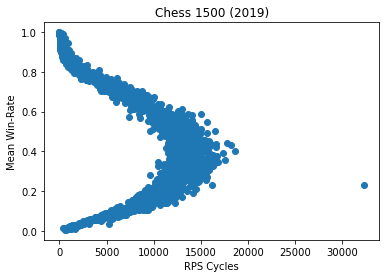

In [19]:
rpp_tuples, rpp_sign_tuples, rpp_mat = generate_RPP_data(nash_clusters, payoff)
adj, strat_winrate = generate_RPS_data(payoff)
plot_RPS(adj, strat_winrate, title)

In [27]:
y_data = rpp_sign_tuples[:, 0]; x_data = rpp_sign_tuples[:, 1]
np.random.seed(888)
init = np.random.uniform(1, 3, size = (5))
print(init)
params = fit_skewed_normal(init, x_data, y_data)
print(params)

[2.71912121 1.32913899 1.96695192 2.84205453 1.85711288]
[ 3.06266644e-01  4.32035921e-01 -2.94254070e-03  5.46103564e+01
  2.00509202e+00]


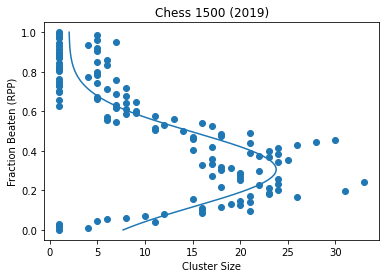

In [20]:
seed = 888
params = plot_nash_clusters_3(rpp_sign_tuples, title, seed)

In [21]:
savePickle(params, '2019 NC Plot Params 1500 12')
savePickle(nash_clusters, '2019 Nash Clusters 1500 12')
savePickle(rpp_sign_tuples, '2019 rpp sign tuples 1500 12')
savePickle(rpp_tuples, '2019 rpp tuples 1500 12')
savePickle(rpp_mat, '2019 rpp mat 1500 12')

<AxesSubplot:title={'center':'Chess 1500 (2019)'}>

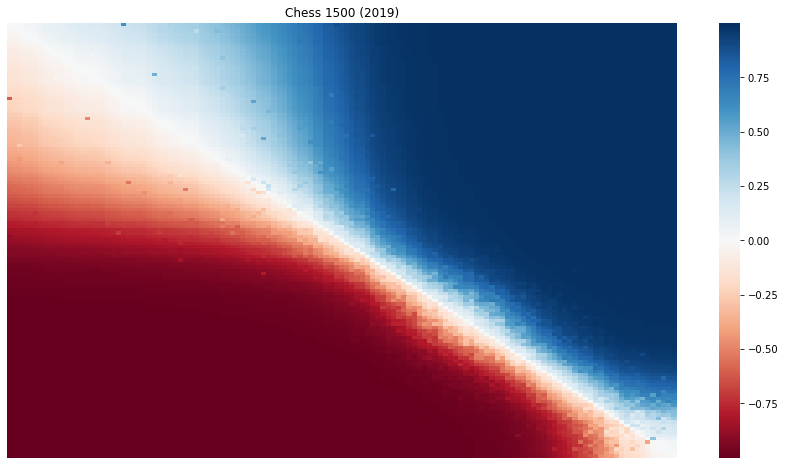

In [26]:
plt.figure(figsize = (15,8))
plt.title(title)
sb.heatmap(rpp_mat, cmap = 'RdBu', xticklabels = False, yticklabels = False, annot = False)

In [31]:
savePickle(payoff, 'Data/2018/ChessPayoff12 1500')
savePickle(markers, 'Data/2018/ChessMarkers12 1500')

### Histogram Data Extraction

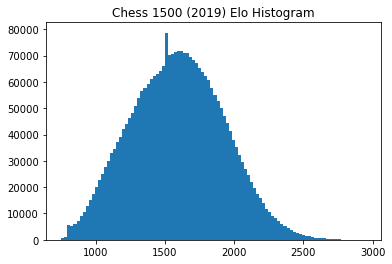

In [27]:
year = 2019
elos = np.concatenate([white_elos, black_elos])
bins = create_bins(750, 2950, 100)
bins = np.array(bins)
hist_bins = np.concatenate([bins[:, 0], [2950]])
plt.title(title + ' Elo Histogram')
out = plt.hist(elos, bins = hist_bins)

In [39]:
print(np.min(elos))
np.max(elos)

600


3184

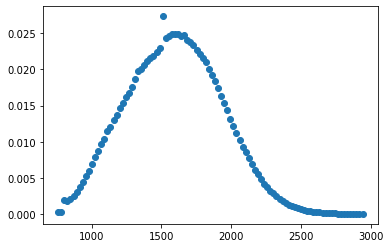

In [28]:
# Data to reproduce plots
counts = out[0]; act_counts = counts
mid_bins = np.mean(bins, axis = 1)
counts = counts / np.sum(counts)
plt.scatter(mid_bins, counts)
set_data = [mid_bins, counts]
count_data = [mid_bins, act_counts]
# savePickle(set_data, 'Data/'+ str(year)+ '/Histogram Data')

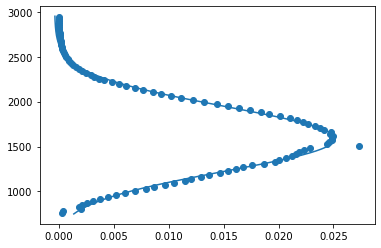

In [29]:
# Fit skewed normal
plt.scatter(counts, mid_bins)
seed = 888
np.random.seed(seed)
y_data = counts; x_data = mid_bins
init = np.random.uniform(0, 0.5, size = (5))
init[0] = 1500; init[1] = 10 * np.sqrt(2)
params = fit_skewed_normal(init, x_data, y_data)

inputs = np.linspace(750, 2950, 1500)
outputs = affine_skewed_normal_pdf(params, inputs)
plt.plot(outputs, inputs)

In [30]:
# Save fitted params so no need to repeat
savePickle(params, 'Data/'+str(year)+'/Histogram Param')
savePickle(set_data, 'Data/'+ str(year)+ '/Histogram Data')
savePickle(elos, 'Data/'+str(year)+'/Histogram Elos')
savePickle(count_data, 'Data/'+str(year)+'/Histogram Count Data')

### Training Data Extraction

In [31]:
# With Uniform

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def generate_training_data(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")


            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def plot_training(win_rates_results, title, save = False):
    plt.figure(figsize = (10,8))
    plt.title(title)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        plt.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    plt.xlabel('Iterations')
    plt.ylabel('Mean Win Rate')
    plt.legend(title = 'Population Size')
    
    if save:
        plt.savefig('Training Plots.pdf')

In [32]:
payoff = openPickle('Data/2019/ChessPayoff12 1500')

In [33]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances = generate_training_data(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
First Reached Peak at 1539
Population Size 75
First Reached Peak at 1429
Population Size 100
First Reached Peak at 1400
Population Size 150
First Reached Peak at 1350
Population Size 200
First Reached Peak at 1300
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


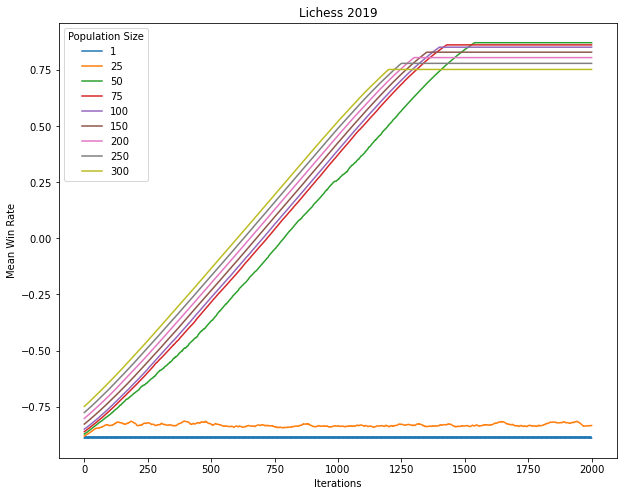

In [34]:
plot_training(training_performances, 'Lichess 2019')

In [35]:
savePickle(training_performances, 'Lichess 2019 Training Uniform')

In [36]:
# With Nash
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def compute_win_rate3(curr_strat_idx, payoff):
    # With Nash
    pop_size = len(curr_strat_idx)
    taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
    taken_payoff = payoff[taken_idx[:, 0], taken_idx[:, 1]].reshape(pop_size, pop_size)
    p_vect, _ = solve_MaxEnt_NE(taken_payoff)
    prob_vect = np.zeros((payoff.shape[0]))
    prob_vect[curr_strat_idx] = p_vect
    return np.mean(prob_vect.reshape(1, -1) @ payoff)

def generate_training_data3(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        if pop_size == 1:
            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        else:
            win_rates.append(compute_win_rate3(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False; prev_win_rate = 0
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")

            if pop_size == 1:
                win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            else:
                if converge:
                    win_rates.append(prev_win_rate)
                else:
                    prev_win_rate = compute_win_rate3(curr_strat_idx, payoff)
                    win_rates.append(prev_win_rate)
                    
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
#         print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)

In [37]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances_nash = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
MOSEK FAILED?


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Population size 25 doesn't converge
Population Size 50
First Reached Peak at 1539
Population Size 75
First Reached Peak at 1429
Population Size 100
First Reached Peak at 1400
Population Size 150
First Reached Peak at 1350
Population Size 200
First Reached Peak at 1300
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


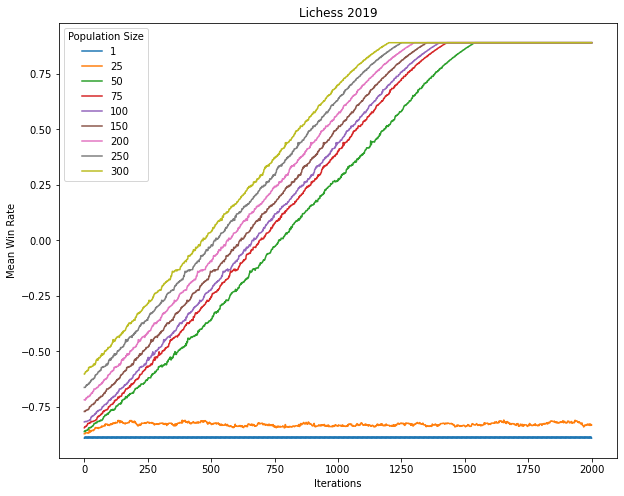

In [38]:
plot_training(training_performances_nash, 'Lichess 2019')

In [39]:
savePickle(training_performances_nash, 'Lichess 2019 Training Nash')